# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_dmh7mjs
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_dmh7mjs
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397885 sha256=509e509742ff28988ddb060d01cc79e9186f1369364324f3693c2f6a1d1a302b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ypo4xn_7/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [2]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2023-03-11 00:40:56--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  67.7MB/s    in 0.8s    

2023-03-11 00:40:57 (67.7 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-03-11 00:40:57--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-03-11 00:40:57--
Total wall clock time: 0.9s
Downloaded: 1 files, 51M in 0.8s (67.7 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

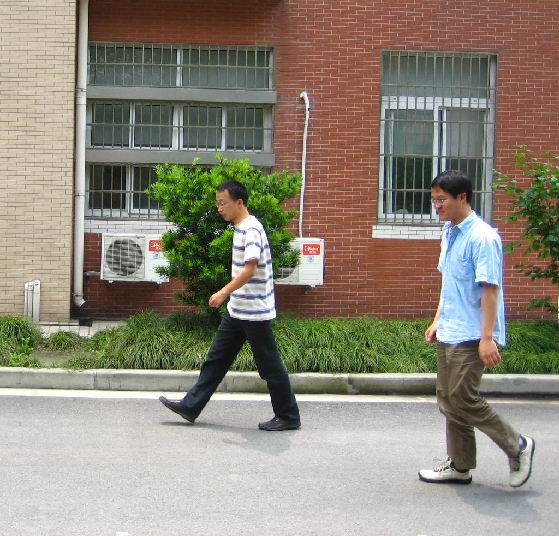

In [3]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [5]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F55F8D28A30>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to try both the approaches so we define `get_instance_segmentation_model` following approach number 1 and `get_instance_segmentation_model_modify` following approach number 2.

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_instance_segmentation_model_modify(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = MaskRCNN(backbone=resnet_fpn_backbone('resnet101', pretrained=True), num_classes=num_classes)
    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 316973, done.
remote: Total 316973 (delta 0), reused 0 (delta 0), pack-reused 316973
Receiving objects: 100% (316973/316973), 644.56 MiB | 34.12 MiB/s, done.
Resolving deltas: 100% (291371/291371), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [8]:
%load utils.py
%load transforms.py
%load coco_eval.py
%load engine.py
%load coco_utils.py



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [10]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now let's instantiate the approach 1 model and the optimizer

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [12]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:08:13  lr: 0.000090  loss: 2.7899 (2.7899)  loss_classifier: 0.7401 (0.7401)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 8.2219  data: 0.4985  max mem: 2162
Epoch: [0]  [10/60]  eta: 0:01:05  lr: 0.000936  loss: 1.3954 (1.7269)  loss_classifier: 0.5156 (0.4824)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7157 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.3093  data: 0.0533  max mem: 3320
Epoch: [0]  [20/60]  eta: 0:00:38  lr: 0.001783  loss: 1.0073 (1.2306)  loss_classifier: 0.2229 (0.3356)  loss_box_reg: 0.2923 (0.2861)  loss_mask: 0.3236 (0.5872)  loss_objectness: 0.0109 (0.0171)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5960  data: 0.0087  max mem: 3320
Epoch: [0]  [30/60]  eta: 0:00:25  lr: 0.002629  loss: 0.5635 (1.0164)  loss_classifier: 0.0996 (0.2559)  loss_box_reg: 0.2702 (0.2871)  loss_mask: 0.1832 (0.4537)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image



In [13]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [14]:
prediction

[{'boxes': tensor([[ 62.0622,  37.1473, 197.7296, 324.8502],
          [276.5457,  23.9642, 290.9383,  73.2073]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9987, 0.4421], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

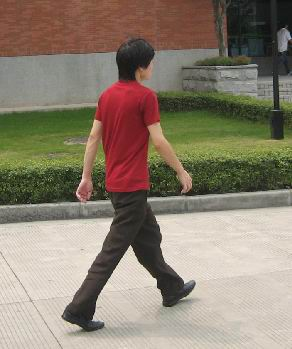

In [15]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

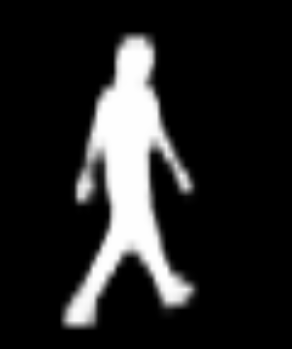

In [16]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Now we load the Beatles test image to identify the Beatles in it

In [17]:
import torch
import numpy as np
from PIL import Image

# Set the path to the JPEG image
jpg_path = "Beatles.jpg"

# Step 1: Open the JPEG image and convert it to a numpy array
img = Image.open(jpg_path)
img_np = np.array(img)

# Step 2: Convert the numpy array to a PyTorch tensor
img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255

# Step 3: Create the metadata object
metadata = {'boxes': torch.tensor([[170.,  21., 319., 311.]]),
            'labels': torch.tensor([1]),
            'masks': torch.tensor(np.zeros((img_np.shape[0], img_np.shape[1], 1), dtype=np.uint8)),
            'image_id': torch.tensor([155]),
            'area': torch.tensor([43210.]),
            'iscrowd': torch.tensor([0])}

# Combine the image tensor and metadata into a single object
img_object = (img_tensor, metadata)

In [18]:
# pick one image from the test set
img, _ = img_object
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [19]:
prediction

[{'boxes': tensor([[ 89.7744, 164.9192, 145.5137, 273.1255],
          [ 21.2697, 161.5482,  80.1468, 271.3481],
          [149.8382, 169.1257, 217.6181, 286.0284],
          [222.4615, 165.0412, 284.4876, 286.1395],
          [239.2916, 148.1905, 245.3226, 173.0860],
          [ 39.7084, 163.7103, 248.6452, 274.7164]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9841, 0.9831, 0.9671, 0.9230, 0.5614, 0.1805], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0., 

Lets first print the original Beatles image

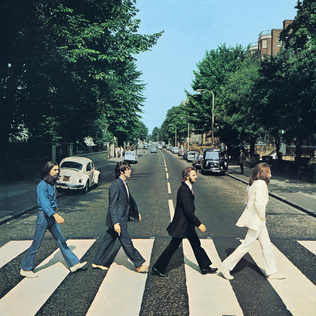

In [20]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize predicted segmentation mask for the Beatles image wit a confidence score higher than 0.75. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

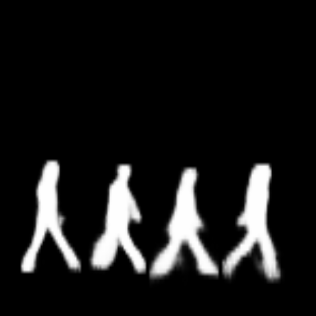

In [21]:
im_arr = np.zeros(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy().shape, dtype=np.uint8)
for i in range(prediction[0]['scores'].cpu().numpy().size):
  if prediction[0]['scores'][i].cpu().numpy() >= 0.75:
    im_arr = im_arr + prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
Image.fromarray(im_arr)

Now let's instantiate the approach 2 model and the optimizer

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model_modify = get_instance_segmentation_model_modify(num_classes)
# move model to the right device
model_modify.to(device)

# construct an optimizer
params = [p for p in model_modify.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [23]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_modify, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_modify, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:58  lr: 0.000090  loss: 3.2753 (3.2753)  loss_classifier: 0.6881 (0.6881)  loss_box_reg: 0.0056 (0.0056)  loss_mask: 1.9025 (1.9025)  loss_objectness: 0.6777 (0.6777)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.9806  data: 0.2713  max mem: 3360
Epoch: [0]  [10/60]  eta: 0:00:37  lr: 0.000936  loss: 2.6416 (2.6477)  loss_classifier: 0.6343 (0.6294)  loss_box_reg: 0.0047 (0.0067)  loss_mask: 1.3097 (1.3197)  loss_objectness: 0.6762 (0.6766)  loss_rpn_box_reg: 0.0126 (0.0153)  time: 0.7509  data: 0.0349  max mem: 4259
Epoch: [0]  [20/60]  eta: 0:00:30  lr: 0.001783  loss: 1.9370 (2.2176)  loss_classifier: 0.4967 (0.4894)  loss_box_reg: 0.0094 (0.0172)  loss_mask: 0.8110 (1.0322)  loss_objectness: 0.6737 (0.6621)  loss_rpn_box_reg: 0.0126 (0.0167)  time: 0.7526  data: 0.0105  max mem: 4259
Epoch: [0]  [30/60]  eta: 0:00:23  lr: 0.002629  loss: 1.5262 (1.9375)  loss_classifier: 0.1932 (0.3711)  loss_box_reg: 0.0610 (0.0504)  loss_mask: 0.6889 (0.9193)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [24]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model_modify.eval()
with torch.no_grad():
    prediction_modify = model_modify([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [25]:
prediction_modify

[{'boxes': tensor([[ 83.9502,  42.7590, 173.5144, 313.9349],
          [ 71.3132, 221.0215, 118.5703, 336.7844],
          [ 81.7100, 169.5750, 179.6706, 292.6075],
          [ 65.9895,  32.0805, 191.3255, 221.1095],
          [ 71.8551, 258.9256, 101.9058, 344.7412],
          [270.1930,  19.2621, 292.0000,  86.1171],
          [159.4060, 246.1536, 186.3060, 324.1355],
          [ 75.3556,  72.6357, 135.4389, 220.9017],
          [149.9064, 228.8714, 178.0675, 317.8501],
          [ 61.9726, 123.8872, 195.1728, 235.6541],
          [ 28.1500,  71.3658, 225.1588, 240.0983],
          [ 58.8632, 127.6896, 196.4151, 334.4869],
          [166.8591, 138.1329, 192.6622, 207.1429],
          [ 46.6317, 256.2628, 114.8374, 333.7109],
          [111.0662,  38.8165, 156.4929,  91.8904],
          [ 61.2710, 285.1154, 104.9320, 335.3816],
          [ 48.1030,  73.5335, 195.4205, 176.1753]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

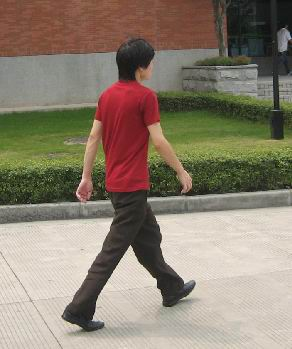

In [26]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

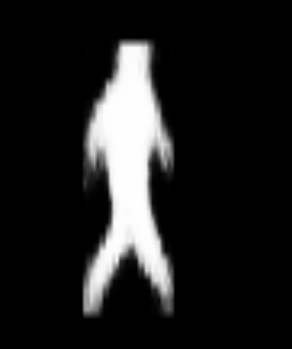

In [27]:
Image.fromarray(prediction_modify[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Now we load the Beatles test image to identify the Beatles in it

In [28]:
import torch
import numpy as np
from PIL import Image

# Set the path to the JPEG image
jpg_path = "Beatles.jpg"

# Step 1: Open the JPEG image and convert it to a numpy array
img = Image.open(jpg_path)
img_np = np.array(img)

# Step 2: Convert the numpy array to a PyTorch tensor
img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255

# Step 3: Create the metadata object
metadata = {'boxes': torch.tensor([[170.,  21., 319., 311.]]),
            'labels': torch.tensor([1]),
            'masks': torch.tensor(np.zeros((img_np.shape[0], img_np.shape[1], 1), dtype=np.uint8)),
            'image_id': torch.tensor([155]),
            'area': torch.tensor([43210.]),
            'iscrowd': torch.tensor([0])}

# Combine the image tensor and metadata into a single object
img_object = (img_tensor, metadata)

In [29]:
# pick one image from the test set
img, _ = img_object
# put the model in evaluation mode
model_modify.eval()
with torch.no_grad():
    prediction_modify = model_modify([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [30]:
prediction_modify

[{'boxes': tensor([[ 89.8591, 159.6635, 145.7437, 285.2675],
          [158.2508, 163.9990, 211.7014, 285.9888],
          [ 20.5442, 160.6710,  70.7836, 280.4715],
          [228.7841, 159.6354, 279.4453, 285.1766],
          [112.6781, 169.9475, 212.8417, 307.0815],
          [ 17.7471, 159.1075, 182.1089, 298.8623],
          [ 24.0778, 178.3772,  71.9506, 242.4665],
          [ 66.6297, 189.7466, 206.8992, 278.1249],
          [ 14.2976, 105.4045,  81.5179, 292.6522],
          [160.4271, 190.3389, 210.4129, 255.1692],
          [186.6893, 163.8991, 285.1202, 302.8577],
          [ 11.1861, 202.5181, 143.4592, 277.0000],
          [ 92.7830, 185.3410, 124.1187, 291.8695],
          [245.4198, 157.0946, 277.7425, 256.9708],
          [ 93.6534, 144.5630, 284.0411, 291.7414],
          [136.6738, 184.2233, 288.4338, 271.6122],
          [ 61.7658, 124.7352, 133.8615, 300.1862],
          [ 56.6349, 128.2188, 216.3918, 315.7168],
          [230.4201, 194.1057, 276.6047, 255.8051],
   

Lets first print the original Beatles image

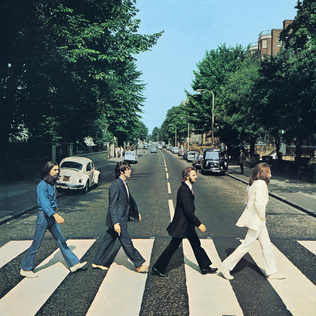

In [31]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize predicted segmentation mask for the Beatles image wit a confidence score higher than 0.75. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

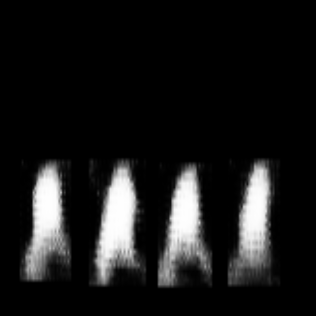

In [33]:
im_arr = np.zeros(prediction_modify[0]['masks'][0, 0].mul(255).byte().cpu().numpy().shape, dtype=np.uint8)
for i in range(prediction_modify[0]['scores'].cpu().numpy().size):
  if prediction_modify[0]['scores'][i].cpu().numpy() >= 0.75:
    im_arr = im_arr + prediction_modify[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
Image.fromarray(im_arr)